<a href="https://colab.research.google.com/github/c-c-c-c/dm_integration/blob/master/myMecab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 吉村インテグレーションステップ 

目的は、ドラマの構成/脚本として、「どのタイミングで」「どんな
出来事」が起こると良いかという示唆を見出すこと。

★目的変数
　　ドラマの初回視聴率からの上下動(%で、閾値を良い、悪い、
　　普通になるように３パターン準備)

★特徴量
　　-ドラマを恋愛、刑事、ヒューマンなどのカテゴリーに分ける
　　-さらに、ドラマをステージ(序盤、中盤、終盤)に分ける
　　-ドラマ名-ステージを行にした、単語×ドラマステージ行列を作成

★モデル
　　- 目的変数に対しロッソ回帰を行う。
　　- もしくは、教師なしのグルーピングを行う。(kmeans, トピックモデル)

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.5)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.8)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.3)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+mai

In [108]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-NEologd] :     diff => ok
[install-mecab-ipadic-NEologd] :     tar => ok
[install-mecab-ipadic-NEologd] :     unxz => ok
[install-mecab-ipadic-NEologd] :     xargs => ok
[install-mecab-ipadic-NEologd] :     grep => ok
[install-mecab-ipadic-NEo

In [109]:
pip install chardet

In [0]:
import joblib
import MeCab
import numpy as np
import pandas as pd
import re
import json
import pprint
import IPython.core.display as display
import IPython.display
from PIL import Image
# import wordcloud, codecs
from wordcloud import WordCloud
from scipy.sparse import csr_matrix

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC

## データの読み込み

In [0]:
# EPGデータ(手作業での修正中))
df_epg = pd.read_excel("./drive/My Drive/0_インテグ作業/data/EPG_checking0212.xlsx")

In [0]:
f= open("./drive/My Drive/0_インテグ作業/data/drama_category0220.json", 'r')

drama_category_dic = json.load(f) #JSON形式で読み込む



In [0]:
# pprint.pprint(drama_category_dic)

In [0]:
f= open("./drive/My Drive/0_インテグ作業/data/drama_win_lose_std.json", 'r')

drama_win_lose_dic = json.load(f) #JSON形式で読み込む



In [0]:
df_epg["sharp_epg_tknz"] = np.nan

In [0]:
# ゴミ除去

def removeTrash (text):
    import re

    result_text = text
    result_text = re.sub(r"https?://[\w/:%#\$&\?\(\)~\.=\+\-]+", "", result_text)
    result_text = re.sub(r"番組詳細|制作・著作|制作著作|・", "", result_text)
    result_text = re.sub(r"[!\(\)=『』～/]", "", result_text)
    result_text = re.sub(r"フジテレビ|日本テレビ|TBS|テレビ朝日|TBS|関西テレビ", "", result_text)
    result_text = re.sub(r"\d+", "", result_text)
    
    result_text = re.sub(r"【公式.*?】", "", result_text)
    result_text = re.sub(r"\u3000", "", result_text)

    return result_text


In [117]:
mecab = MeCab.Tagger()
mecab.parse("")
for i, text in enumerate( df_epg['sharp_epg_hand_corrected']):
    text_tokenized = []

    # URL、記号などのゴミを取り除く
    if type(text) is not str: 
        if np.isnan(text) :
            continue 
    text = removeTrash(text)
    node = mecab.parseToNode(text)
    while node:
        node = node.next
        if node is None:
            continue

        if not node.feature.startswith("BOS/EOS") and not node.feature.startswith("助詞") and\
            not node.feature.startswith("記号") and\
            node.feature.find("人名") == -1 and\
            not node.feature.startswith("助動詞"):
            text_tokenized.append(node.surface)

    df_epg["sharp_epg_tknz"].iloc[i] = text_tokenized

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# 手作業での前処理が完了してないので、完了したものだけにする
bool_list = [] 

for i in range(len(df_epg["sharp_epg_hand_corrected"])):
    bool_list.append( type( df_epg["sharp_epg_tknz"].iloc[i] ) != float )

In [0]:
df_notnull =  df_epg[bool_list]

In [120]:
df_notnull["phys_cnt"] = np.nan
df_notnull["category"] = np.nan
df_notnull =  df_notnull.rename(columns={ 'Unnamed: 0' : 'sort_id' } )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
drama_category_dic.keys()

dict_keys(['love', 'police'])

In [122]:
# 物理カウントとカテゴリーを加える
love_cnt = 0
police_cnt = 0
for tmp_key  in df_notnull["drama_key"].unique():
    cnt = 0

    if tmp_key in drama_category_dic["love"]:
        love_cnt += 1

        qry_l = " drama_key == @tmp_key"
        target_idx = df_notnull.query(qry_l).index
        df_notnull[ "category" ].loc [target_idx] = "love"


    if tmp_key in drama_category_dic["police"]:
        police_cnt += 1
        qry_p = " drama_key == @tmp_key"
        target_idx = df_notnull.query(qry_p).index
        df_notnull[ "category" ].loc [target_idx] = "police"

    for sort_id in  df_notnull[df_notnull["drama_key"] == tmp_key]['sort_id'].values:
        cnt  += 1

        qry = " sort_id == @sort_id"
        target_idx = df_notnull.query(qry).index
        df_notnull["phys_cnt"].loc[target_idx] = cnt

    # print(tmp_key)



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# if drama_win_lose_dic.get("1910_EX_木21") :
#     drama_win_lose_dic["1910_EX_木22'"] = drama_win_lose_dic["1910_EX_木21"]
#     drama_win_lose_dic.pop("1910_EX_木21")
#     print("come")

In [124]:
drama_win_lose_dic["1910_EX_木22"]

# drama_win_lose_dic.keys()

0.342080551878877

In [0]:
# df_stage ステージごとに作る

df_stage = pd.DataFrame( columns=['drama_key','drama_title','stages','epg_joined','drama_category','win_lose'] )


for tmp_key in df_notnull.drama_key.unique():

    # win_or_lose = ""
    # if tmp_key in drama_win_lose_dic["win"]:
    #     win_or_lose = "win"
    # elif tmp_key in drama_win_lose_dic["draw"]:
    #     win_or_lose = "draw"
    # elif tmp_key in drama_win_lose_dic["lose"]:
    #     win_or_lose = "lose"
    # else:
    #     print("????")

    tmp_cat = str(df_notnull[ df_notnull["drama_key"] == tmp_key ].category.values[0])
    tmp_title = str(df_notnull[ df_notnull["drama_key"] == tmp_key ].drama_title.values[0])
    win_or_lose = drama_win_lose_dic[tmp_key]

    for tmp_stage in ["early","middle" ,"late"]:

        qry = ""
        if tmp_stage == "early":
            qry = "drama_key == @tmp_key & phys_cnt < 4 "

        elif tmp_stage == "middle":
            qry = "drama_key == @tmp_key & 4< phys_cnt < 7 "

        else:
            qry = "drama_key == @tmp_key & phys_cnt >= 7 "

        target_i =  df_notnull.query(qry)["sharp_epg_hand_corrected"]
        epg_joined = str(df_notnull.query(qry)["sharp_epg_hand_corrected"].values)

        tmp_se = pd.Series( [ tmp_key, tmp_title,tmp_stage, epg_joined  ,tmp_cat, win_or_lose ]  , index=df_stage.columns  )
        df_stage = df_stage.append( tmp_se, ignore_index=True )



In [126]:
df_stage.iloc[1:200]


,drama_key,drama_title,stages,epg_joined,drama_category,win_lose
1,1910_CX_月21,シャーロック,middle,['若宮潤一(岩田剛典)が誉獅子雄(ディーン・フジオカ)に文句を言っている。獅子雄は、同居し...,police,-0.693990
2,1910_CX_月21,シャーロック,late,['誉獅子雄(ディーン・フジオカ)と若宮潤一(岩田剛典)が、いつものようにもめている。自分の...,police,-0.693990
3,1910_CX_火22,まだ結婚できない男,early,['桑野信介(阿部寛)は腕のいい建築士だが、「メリットがない」という考えから結婚の経験はなく...,nan,-0.361362
4,1910_CX_火22,まだ結婚できない男,middle,['かねてから鎌倉の仏像を愛してやまない、まどか(吉田羊)は、1泊2日の鎌倉旅行に有希江(稲...,nan,-0.361362
5,1910_CX_火22,まだ結婚できない男,late,['ある日、桜子(咲妃みゆ)から、店舗デザインの仕事を持ち掛けられた桑野(阿部寛)。人が住む...,nan,-0.361362
6,1910_CX_木22,モトカレマニア,early,['現在失業中の27歳独身・難波ユリカ(新木優子)は、見た目にも気を使い、コミュニケーション...,love,-0.520001
7,1910_CX_木22,モトカレマニア,middle,['マコチ(高良健吾)は、ユリカ(新木優子)のもとへ謝りに行ったものの、追い返されてしまう。...,love,-0.520001
8,1910_CX_木22,モトカレマニア,late,['ユリカ(新木優子)は、マコチ(高良健吾)から「好きだ」と告白され、もう一度彼と付き合うこ...,love,-0.520001
9,1907_CX_木22,ルパンの娘,early,['☆笑い&ラブ&家族ドラマ&サスペンス&アクション&ミュージカル!エンタメてんこ盛りの贅沢...,nan,-0.087562
10,1907_CX_木22,ルパンの娘,middle,['☆田中みな実演じる女泥棒が大暴れ!深田恭子と新旧ドロンジョ対決!!今夜もツッコミが追いつ...,nan,-0.087562


In [0]:
# 空の列を足す
df_stage["epg_tknz"] = np.nan

In [128]:
mecab = MeCab.Tagger()
mecab.parse("")
for i, text in enumerate( df_stage['epg_joined']):
    text_tokenized = []

    # URL、記号などのゴミを取り除く
    if type(text) is not str: 
        if np.isnan(text) :
            continue 
    text = removeTrash(text)
    node = mecab.parseToNode(text)
    while node:
        node = node.next
        if node is None:
            continue

        if not node.feature.startswith("BOS/EOS") and not node.feature.startswith("助詞") and\
            not node.feature.startswith("記号") and\
            node.feature.find("人名") == -1 and\
            not node.feature.startswith("助動詞"):
            text_tokenized.append(node.surface)

    df_stage["epg_tknz"].iloc[i] = text_tokenized

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [129]:
df_stage["epg_tknz"]

0       [[', 都内, ある, 病院, 中庭, この, 病院, 勤務, する, 消化, 器, 内科...
1       [[', 典, 誉, 獅子, 雄, ディーンフジオカ, 文句, 言っ, いる, 同居, し,...
2       [[', ディーンフジオカ, 典, いつも, よう, もめ, いる, 自分, スイーツ, 食...
3       [[', 腕, いい, 建築, 士, メリット, ない, 考え, 結婚, 経験, さらに, ...
4       [[', かね, 鎌倉, 仏像, 愛し, やま, 羊, 泊, 日, 鎌倉, 旅行, 誘う, ...
                              ...                        
1906    [[', 鈴, 相, 武, 紗, 季, 会お, オリオン, 座, 忍び込ん, クロワッサン,...
1907    [[', 静岡, 県, 浜松, 市, コンサート, 趣旨, 賛同, し, 歌手, たち, 熱...
1908    [[', 人生, 先, 見え, 始め, 中年, 男性, 昔, 恋人, そっくり, 二, 十,...
1909    [[', 虫垂炎, 入院, し, 病院, 駆け付け, ユリ, 付き添う, 小, 百, 合, ...
1910    [[', 自分, ない, こと, ユリ, 知ら, れ, しまっ, うそ, つい, い, こと...
Name: epg_tknz, Length: 1911, dtype: object

In [0]:

df_stage["win_lose_dummy"] = df_stage["win_lose"]

In [0]:
# df_stage["win_lose_dummy"] = np.nan
# for i in range(len( df_stage["win_lose"] )):

#     if df_stage["win_lose"].iloc[i] == "win":
#         df_stage["win_lose_dummy"].iloc[i] = 1

#     elif df_stage["win_lose"].iloc[i] == "draw":
#         df_stage["win_lose_dummy"].iloc[i] = 0

#     elif df_stage["win_lose"].iloc[i] == "lose":
#         df_stage["win_lose_dummy"].iloc[i] = -1
        
#     else :
#         print("???")
#     # df_stage["win_lose_dummy"] = 

In [0]:
# 行列の中で1より大きい数値を１にならす
def bool_bow ( argX ) :

    # 各要素を見に行って２以上なら１補正
    for j in range(argX.shape[1]):
        tmp_sum = 0
        for i in range(argX.shape[0]):

            if argX[i, j] > 1:
                argX[i, j] = 1

    return argX


In [0]:
frequency_word_dict = {}

In [0]:
def check_rare_words ( argX , pre_vectorizer ) :
    for j in range(argX.shape[1]):
        for i in range(argX.shape[0]):
            if argX[i, j] > 1:
                argX[i, j] =   1
            
    tmp_df_sp = pd.DataFrame(argX.toarray(), columns=[ x[0] for x in sorted(pre_vectorizer.vocabulary_.items(), key=lambda x: x[1]) ])

    result_rare_words =[]

    for   tmp_word in tmp_df_sp.columns:
        tmp_sum = tmp_df_sp[tmp_word].sum()

        if  tmp_sum < 7:
            result_rare_words.append(tmp_word)
        else:
            frequency_word_dict[tmp_word] = tmp_sum
    # import pdb; pdb.set_trace()
    return result_rare_words
    

In [0]:
particular_stop_words =[  '続け', 'それ', 'VTR', 'uB', '会社', 'KEY',\
 '...', "！'", 'なっ', '中', '%', '[', '気', "！！']", 'PC', '目', "['「", 'しかし', '担当', '自分', "?']", "'\\", 'いつも', '入っ', '折', '姿', 'CT',\
  'まだ', '出し', 'くる', '欲しい', '出す', '言う', '店', '出', '"…', "'", '?」', '?', "。']", '頭', 'Sea', '翌日', '準備', '&', "['\\", 'CD', 'もの', 'FIFA', '自宅', 'Ft', 'くれ',\
 'そこで', 'TOKIX', ']', 'My', '元', '。\\', "！！'", '出る', '始める', '思っ', 'SNS', '受け', '思い', '人', '口', "'「", '東京', '今', 'こと', '様子', "？'", '日',\
 'AK', 'ため', '-', 'そして', 'なる', "?'", '顔', '大', '的', 'ない', 'いく', 'やがて', '知っ', '新', '聞く', '来', '\\', '真', '訪れ',\
 '入る', '仕事', "']", '行く', '事務所', '作り', '考え', '戻っ', '知ら', '[]', 'しよ', 'GPS', 'する', "??']", 'しまう', 'られ', '再び', '誰', '言い',\
 "？？']", '話し', '"', ':', '同じ', "['", '話す', "。'", 'いい', '聞き', '言っ', '途中', '朝', '手', '紗', '言わ', \
 "作っ","現れ","自ら","最近","続ける","みんな","ふたり","さらに","果たして","部屋","かさ","聞か","場所","さらに",\
 "室","思わ","円","三","感じ","ころ","見","うち","やってき",\
 "あまり","以前","思う","分から","大きな","話そ","力","私","あまり","本当","関係","向かっ","知り","受ける","送っ","なら","彩",\
 "彼ら","ところ","事情","いる","官","年","き","その頃","際","林","これ","本",\
"二","また","ひとり","よう","ある","し","つけ","始め","行わ","そこ","これ",\
"一方","どこ","不","彼ら","つけ","者","し","よう","今回","いう","れ","その",\
"いる","あり","高い","副","すぐ","さ","つい","数","持つ",\
"利用","出来","れる","状態","なぜ","なんと","伝える","行っ","きっかけ","よう",\
 "取っ"# "せよ", #どうかな？
 ]

In [0]:
# ステージごとに分けた後のdfを引数にとる
not_rare_words = []
particular_stop_words.extend(["いる", "おり", "arata","uend", "c","C" , "この","その" ,"そう","あり","際",\
                        "genking","件","メゾン","しれ","きり","u","U","あり","回",\
                        "お","leola","ください","また",\
                        "後","ー","a","A","なく","or","OR",\
                        "ii","II","まま","皆","百","ーー","j","J","どう","x","X","sit","SIT","通",\
                        "TSUTAYA","かつ","無い","性","しまい","不","陽",\
                        "性","将","点","結","負っ",\
                        "luz","その後","すると","方","屋","ほう","フジオカ","事","二","くれる","leg",\
                         "genking","さ","ところ",\
                         "太郎","数","すると","あげ","上","takahiro",\
                        "み","メゾン","ある","よう","あっ","ほしい","彼ら","状","megumi",\
                         "なぜ","上げ","まるで","nima","NIMA","j","ii","その後","ビョンホン","x",\
                         "tsutaya","頃","げ","史","これ","あ","ディーン・フジオカ","(ディーン・フジオカ)"\
                         "genking","ユリカ", "BAR","FUJIOKA","GENKING","ARATA","X","MEGUMI", "メゾン・フローラル", 
                         "BANZAI","s","S","一","・フローラル","TAKAHIRO","NAYUTAWAVE","GENKING",
                         "でき","他","ウイルステロブラッディ","ただ","RECORDS","KAMIYA","GEROGE","K",
                         "の","ド","たち","ん","ウイルステロブラッディ・マンデイ","ら","が","uFUJIOKA",
                         "れる","し","何","カヲル","いう","ela","いっ","もと","r","だが","僕","アイ","DEAN",
                         "メグリン","シュウメイリン","オリヴィエ","き","uEND","かけ","いっ","し","ザ","れる","コンテンポラリーダンサー・",\
                         "Kis","メグリン","ヴィ","JMT","r","R","smap","SMAP",\
                         "F","そんな","士","ボイスプロファイラー","I","i","asamoto","ASAMOTO","exile","EXILE","ela","ELA","sea","SEA","ny","NY","きれ",
                         "WOWOW","fm","FM","ns","NS","b","B","つい","化","オング","れ","小"
                         "なっ","マコチ","やる","れ","uSons","カヲル","モンロウ","jazz","JAZZ",
                         "つい","あらゆる","化","BONITO","SOS","MRI","られる","MCI","い","そこ","間",
                         "ロン・モンロウ","カレ・カヲル","なかっ","no","NO","長","FILE","W",
                         "SMBC","AP","ECU","メグリン","リュウ","ひかり","Luz","BL","介","内","社","系","平","バチェロレッテ・パーティー"
                         "ca","CA" ,"ft","FT", "mkm", "MKM","no","NO", "uela","UELA",  "yell","YELL"  , "いき"  , "かかっ","こ" ,"しかも","しまっ", "しよ ","すぐ"  ,
                         "すべて", "せ", "せる", "せる", "その頃", "どこ", "なか", "なり", "なんと", "はず", "もう", "もらっ",  "会",  "外", "時", "者", "場", "先", "前", "年",  "聞い", "話",
                         "WEB","側","hoge"
                         
                         
                         
                         ])

def fit_trans_lasso (df_tmp) :
    pre_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
    Xpre = pre_vectorizer.fit_transform(
        [str(i) for i in df_tmp["epg_tknz"].values]
    )
    rare_words = check_rare_words(Xpre, pre_vectorizer)

    # import pdb; pdb.set_trace()
    bow_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")

    global not_rare_words
    not_rare_words= []

    # rare_wordとstop_wordを確認する

    dbg_cnt = 0 ###

    chk_list_merge = rare_words
    chk_list_merge.extend(particular_stop_words)

    chk_list_merge = [ i.lower() for i in chk_list_merge]

    # reg = re.compile( '|'.join(['({})'.format(pat) for pat in chk_list_merge if pat.isalpha()]) )

    for tmp_word_list in  df_tmp["epg_tknz"].values:
        tmp_list = []
        for tmp_word in tmp_word_list:

            if tmp_word.lower() not in chk_list_merge:
                # print("before_chck"+str(tmp_word))
                # if tmp_word not in rare_words and tmp_word not in particular_stop_words:
                
                # if tmp_word.isalpha():
                #     chk_list_merge = rare_words
                #     chk_list_merge.extend(particular_stop_words)
                #     for stpwd in chk_list_merge:
                #         # tmp_reg_ex = 'r"'+ re.escape(stpwd) +'"'
                #         if reg.match(tmp_word , re.IGNORECASE) :
                #continue
                # print("after_chck"+str(tmp_word))
                # if tmp_word == "genking":
                    # print("????why genking???")
                tmp_list.append(tmp_word)
                dbg_cnt +=1###
                
        not_rare_words.append(tmp_list)
        # if dbg_cnt > 20 :###
             ####break ### debug用
            # pass



    X = bow_vectorizer.fit_transform( 
        [str(i) for i in not_rare_words] 
    )
    X = bool_bow( X )

    Y = df_tmp["win_lose_dummy"]

    scaler = StandardScaler(with_mean=False)
    clf = Lasso(alpha=0.014)

    # 標準化する必要はない??
    # X = scaler.fit_transform(X)
    
    clf.fit(X, Y)

    result_df = pd.DataFrame(clf.coef_.T , index=bow_vectorizer.vocabulary_ )

    return result_df


In [0]:
class HorizontalDisplay:
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        template = '<div style="float: left; padding: 10px;">{0}</div>'
        return "\n".join(template.format(arg._repr_html_())
                         for arg in self.args)


In [0]:
#######
# early middle lateステージごとの結果を出す
#

def calc_lasso_by_stage (df_orijin):
    df_early =  df_orijin[df_orijin["stages"] == "early"]
    df_middle =  df_orijin[df_orijin["stages"] == "middle"]
    df_late =  df_orijin[df_orijin["stages"] == "late"]

    result_late = fit_trans_lasso (df_late) 
    result_early = fit_trans_lasso (df_early) 
    result_middle = fit_trans_lasso (df_middle) 

    dfe = result_early[ result_early[0] != 0].sort_values(0)
    dfm =result_middle[ result_middle[0] != 0].sort_values(0)
    dfl =result_late[ result_late[0] != 0].sort_values(0)

    # print(dfl)
    display.display(HorizontalDisplay(dfe, dfm, dfl))

    return (dfe, dfm, dfl)


In [139]:
(love_dfe , love_dfm, love_dfl )   = calc_lasso_by_stage(df_stage[df_stage['drama_category'] =="love"]  )

,0
胸,-0.610709
知る,-0.497145
見合い,-0.409789
誘い,-0.393266
先輩,-0.365751
時代,-0.350705
言い出す,-0.347109
幸せ,-0.347014
笑顔,-0.324697
反対,-0.302514


In [140]:
for tmp_e in df_stage[df_stage['drama_category'] =="love"]["epg_tknz"]:
    print(tmp_e)

["['", '現在', '失業', '中', '歳', '独身', '難波', 'ユリカ', '見た目', '気', '使い', 'コミュニケーション', '下手', 'うまく', '恋愛', 'でき', 'その', '理由', 'マコチ', '"', 'こと', '元', 'カレ', 'あっ', 'ユリカ', '初めて', '恋愛', 'マコチ', '幸せ', '日々', '過ごし', 'ちょっとした', 'すれ違い', '彼', '振っ', 'しまう', 'だが', '次に', '付き合っ', '男', 'クズ', 'その', '次', 'もっと', 'クズ', '失敗', '経', 'ユリカ', '出し', '答え', '幸せ', '過去', '恋', '時間', '浸る', '"', 'こと', '実体験', '元', 'し', '恋愛', '描写', '人気', '小説', '家', '丸の内', 'さくら', '小説', '愛読', 'し', '毎朝', 'SNS', 'マコチ', 'こと', '検索', 'し', 'いる', 'ユリカ', '初対面', '男性', 'マコチ', 'かすか', '共通', '点', '見つける', 'こと', '喜び', '感じ', 'い', '親友', 'ネイリスト', '現実', '見よ', 'ユリカ', '助言', 'する', 'アパート', '更新', '近づい', 'い', 'ユリカ', 'チロリアン', '不動産', '面接', '受ける', '社長', '小手', '部下', '甘', '路', '関口', 'メンディー', 'ハラ', 'ミ', '会', '"', 'ハラスメント', '未然', '防ぐ', '会', '結成', 'する', 'リスクヘッジ', '敏感', '男', 'ユリカ', '強引', 'さ', '押し切ら', 'れ', '仮', '採用', '決める', 'そこで', 'ユリカ', '初めて', '担当', 'し', '客', '大手', '食品', '会社', '勤務', 'そんな', '折', 'ユリカ', '出張', '中', 'もう', '人', '社員', '顔', '合わせる', '何と', 'それ', 'あの', 'マコチ', "。'", "'", 'ユリカ', '

In [0]:
# particular_stop_words

In [142]:
(police_dfe , police_dfm, police_dfl ) = calc_lasso_by_stage(df_stage[df_stage['drama_category'] =="police"]  )

,0
遭遇,-0.646795
街,-0.595757
相棒,-0.456588
仕掛け,-0.442555
組織,-0.272039
見せる,-0.256470
ところが,-0.245389
推理,-0.234543
高級,-0.209073
世界,-0.187748


In [143]:
for tmp_e in df_stage[df_stage['drama_category'] =="police"]["epg_tknz"]:
    print(tmp_e)

["['", '都内', 'ある', '病院', '中庭', 'この', '病院', '勤務', 'する', '消化', '器', '内科', '医', '栄光', 'あ', 'かばね', '慶', '遺体', 'なっ', '発見', 'さ', 'れ', '捜査', '一', '課', '警部', '蔵', '介', '何者', '屋上', '突き落とさ', 'れ', 'の', '病院', '関係', '者', '事情', '聴取', 'する', '患者', '信頼', '厚く', '異性', '関係', 'トラブル', '皆無', '殺さ', 'れる', 'はず', 'ない', '口', 'そろえる', 'その', '様子', '静か', '聞い', 'い', 'の', '犯罪', '捜査', '専門', 'コンサルタント', '誉', '獅子', '雄', 'ディーンフジオカ', '公', 'し', 'い', 'ずばぬけ', '観察', '眼', '天才', '的', '思考', '回路', '持ち合わせる', '獅子', '雄', '力', '時折', '借り', '事件', '捜査', '当たっ', 'いる', '彼ら', '証言', '潜む', '虚偽', '瞬時', '見抜き', '必要', '情報', '不要', '情報', '整理', 'し', 'いく', 'そんな', '中', '事情', '調査', '中', '関わら', 'その', '場', '静か', '立ち去っ', '人', '男', 'い', 'この', '病院', '勤務', 'する', '精神', '科', '医', '典', 'その', '様子', '見逃さ', '彼', '何', '真実', '握っ', 'いる', 'の', '察知', 'し', '重要', '参考', '人', '調査', '開始', 'する', "'", "'", 'ついに', 'バディ', '結成', '最初', '事件', '挑む', '新宿', '駅', '死ん', '女', '別人', '成り代わっ', '女', '"', 'ロック', '対峙', 'する', 'の', '美しき', '弁護士', '天才', '唯一', '惚れ', '特別', '聖女', '息詰まる', '心理', '戦', '開幕

In [144]:
df_nan = df_stage[df_stage['drama_category'] =="nan"]
# win_lose_dummyにnanがあるので・・
df_nan = df_nan[ ~pd.isnull(df_nan['win_lose_dummy'])]

calc_lasso_by_stage(df_nan )



,0
生活,-0.411875
入れる,-0.318852
俺,-0.213658
パーティー,-0.177059
選手,-0.176988
課,-0.176774
塾,-0.161794
中心,-0.161018
一家,-0.152195
地,-0.149716


(              0
 生活    -0.411875
 入れる   -0.318852
 俺     -0.213658
 パーティー -0.177059
 選手    -0.176988
 課     -0.176774
 塾     -0.161794
 中心    -0.161018
 一家    -0.152195
 地     -0.149716
 教える   -0.149157
 それぞれ  -0.147469
 米     -0.146651
 隊     -0.123558
 蔵     -0.117210
 取材    -0.116671
 過ぎ    -0.111049
 決定    -0.110592
 信頼    -0.104684
 目覚め   -0.094577
 犯人    -0.085161
 安全    -0.084701
 怒っ    -0.080655
 同僚    -0.079520
 料理    -0.079485
 急ぐ    -0.077641
 答える   -0.076045
 間近    -0.074127
 居場所   -0.072724
 入社    -0.066390
 向かう   -0.063908
 下     -0.058721
 賭け    -0.045252
 始まる   -0.042715
 藤     -0.039215
 学     -0.038914
 代わり   -0.035545
 目撃    -0.033934
 告げる   -0.031568
 病室    -0.025677
 週刊    -0.024532
 資料    -0.023727
 罪     -0.022211
 弟     -0.020458
 次     -0.019456
 緊急    -0.014596
 発展    -0.014088
 席     -0.013170
 食品    -0.012274
 問題    -0.003919
 失う     0.002594
 命じ     0.002648
 殺さ     0.005100
 しばらく   0.011865
 愛する    0.012545
 恩師     0.012570
 年生     0.018406
 捜索     0.0186

In [0]:
font_path = "./drive/My Drive/0_インテグ作業/fonts/ヒラギノ角ゴシック W6.ttc"

In [146]:
font_path

'./drive/My Drive/0_インテグ作業/fonts/ヒラギノ角ゴシック W6.ttc'

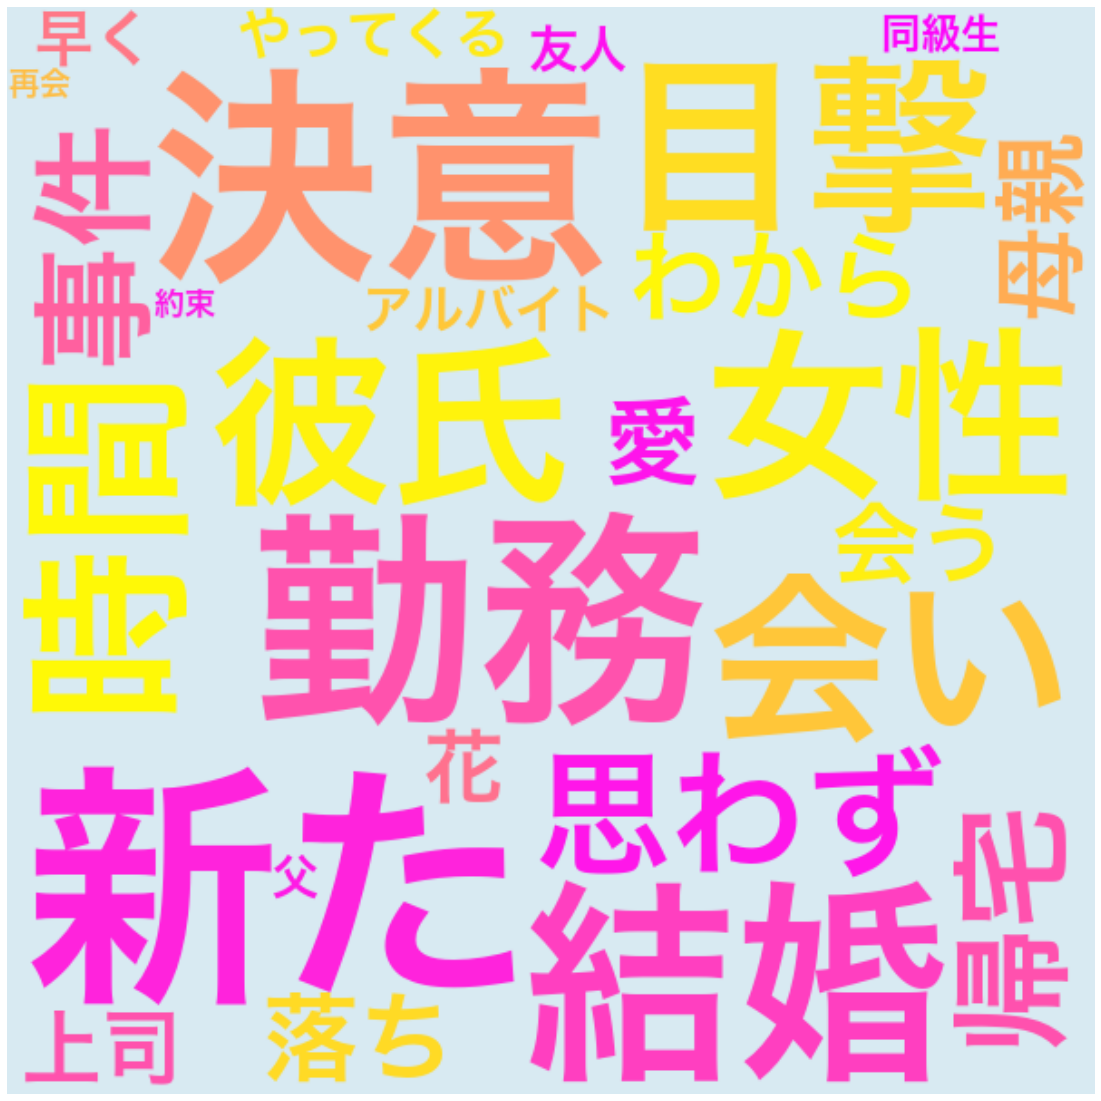

In [147]:
# "./drive/My Drive/0_インテグ作業/fonts/ヒラギノ角ゴシック W3.ttc"
target_df = love_dfe.copy()

target_df = target_df[target_df[0] > 0 ]

target_df[0] = target_df[0] ** 2

target_df[0] =  target_df[0].apply( lambda v : v **0.5  )

wordcloud = WordCloud(background_color='#D8EAF2',
                      font_path = font_path,
                      colormap = "spring",
                      min_font_size=10,
                      max_font_size=140,
                      width=600,
                      height=600)

wordcloud.generate_from_frequencies( target_df[target_df[0] > 0 ][0].to_dict() )
plt.figure(figsize=[20,20])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
# plt.title(fig_title,fontsize=25)
plt.show()
import datetime
tmp_time = datetime.datetime.now()
file_name = str(target_df.index[0]) + str(int(tmp_time.timestamp())) + ".png"
wordcloud.to_file("./drive/My Drive/0_インテグ作業/png/" + file_name)

In [148]:
target_df[0]**2

彼        0.000003
再会       0.000301
約束       0.000328
同級生      0.001069
父        0.002387
友人       0.002992
アルバイト    0.003535
やってくる    0.004726
早く       0.006875
上司       0.027714
花        0.028013
会う       0.042012
母親       0.042247
愛        0.042663
落ち       0.046298
わから      0.050258
事件       0.063679
帰宅       0.064946
思わず      0.100523
時間       0.107830
会い       0.118374
彼氏       0.119490
女性       0.128470
目撃       0.138254
結婚       0.236407
勤務       0.304891
決意       0.315591
新た       0.473116
Name: 0, dtype: float64

In [149]:
print(target_nega_df)

             0
胸     0.781479
知る    0.705085
見合い   0.640148
誘い    0.627109
先輩    0.604774
時代    0.592203
言い出す  0.589160
幸せ    0.589079
笑顔    0.569822
反対    0.550013
答える   0.512677
ところが  0.495570
ドラマ   0.477436
母     0.475196
慌て    0.470900
秘密    0.454845
久しぶり  0.454107
帰っ    0.419757
一緒    0.378323
面々    0.366994
提案    0.364594
頼む    0.356614
働く    0.337171
夫     0.316199
見る    0.311689
出会っ   0.257479
尋ねる   0.235878
キス    0.225429
惹か    0.213423
家     0.184730
メール   0.171923
初めて   0.123126
誕生    0.117298
食事    0.112904
後輩    0.092284
人生    0.046789


             0
胸    -0.610709
知る   -0.497145
見合い  -0.409789
誘い   -0.393266
先輩   -0.365751
時代   -0.350705
言い出す -0.347109
幸せ   -0.347014
笑顔   -0.324697
反対   -0.302514
答える  -0.262838
ところが -0.245590
ドラマ  -0.227946
母    -0.225811
慌て   -0.221747
秘密   -0.206884
久しぶり -0.206213
帰っ   -0.176196
一緒   -0.143128
面々   -0.134685
提案   -0.132928
頼む   -0.127173
働く   -0.113684
夫    -0.099982
見る   -0.097150
出会っ  -0.066295
尋ねる  -0.055638
キス   -0.050818
惹か   -0.045549
家    -0.034125
メール  -0.029557
初めて  -0.015160
誕生   -0.013759
食事   -0.012747
後輩   -0.008516
人生   -0.002189


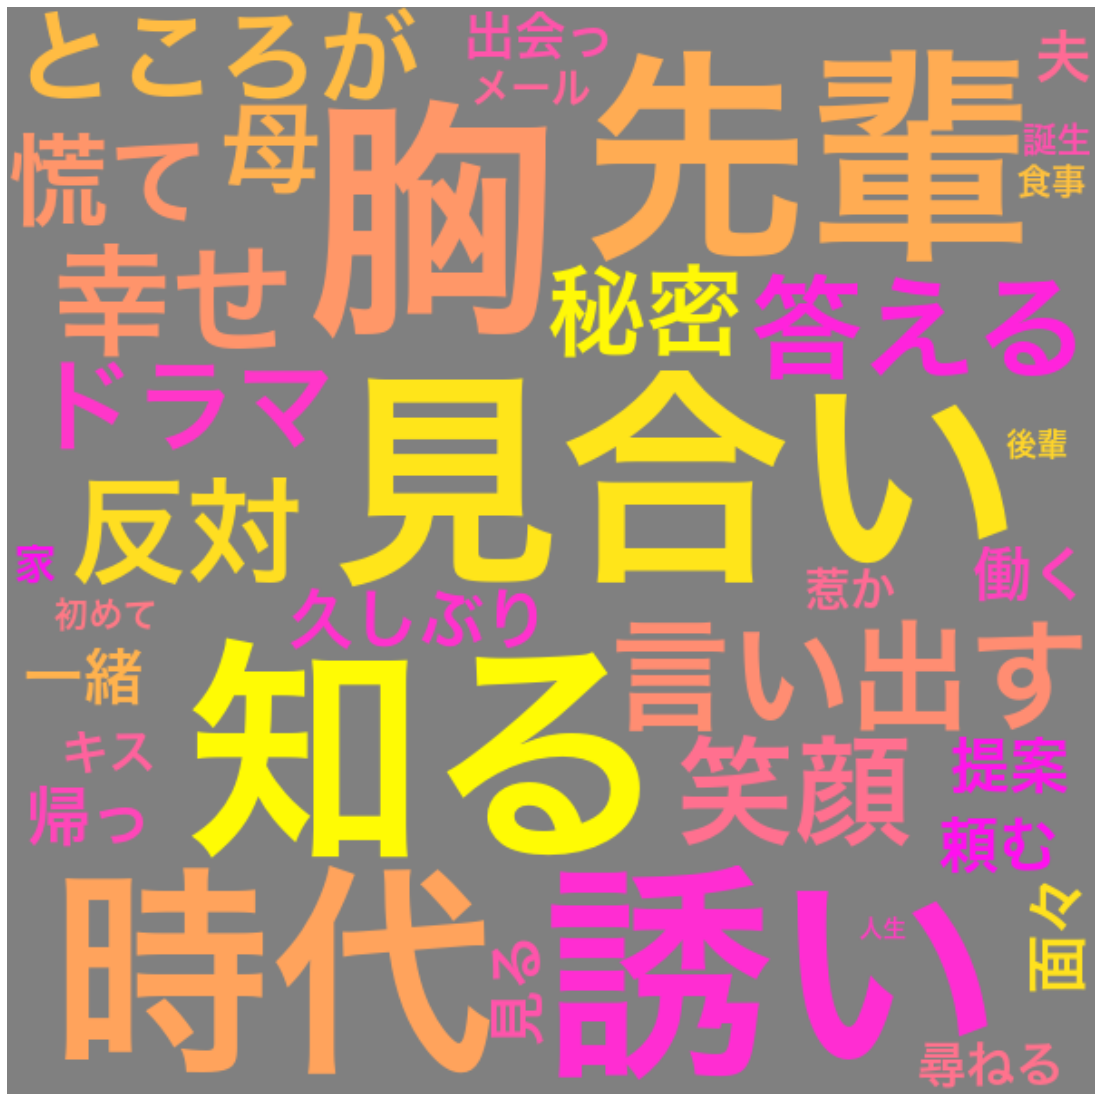

In [150]:
# "./drive/My Drive/0_インテグ作業/fonts/ヒラギノ角ゴシック W3.ttc"
target_nega_df = love_dfe.copy()

target_nega_df = target_nega_df[target_nega_df[0] <0]
print(target_nega_df)

target_nega_df[0] =  -target_nega_df[0]
target_nega_df[0] =  target_nega_df[0].apply( lambda v : v **0.5  )


wordcloud = WordCloud(background_color='gray',
                      font_path = font_path,
                      colormap = "spring",
                      min_font_size=10,
                      max_font_size=140,
                      width=600,
                      height=600)

wordcloud.generate_from_frequencies(target_nega_df[target_nega_df[0] > 0 ][0].to_dict())
plt.figure(figsize=[20,20])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
# plt.title(fig_title,fontsize=25)
plt.show()
import datetime
tmp_time = datetime.datetime.now()
file_name = str(target_df.index[0]) + str(int(tmp_time.timestamp())) + ".png"
wordcloud.to_file("./drive/My Drive/0_インテグ作業/png/" + file_name)

In [0]:
# from PIL import Image
# import wordcloud, codecs
# wordc = wordcloud.WordCloud(font_path='HGRGM.TTC',
#         background_color='white',
#         mask=msk,
#         contour_color='steelblue',
#         contour_width=2).generate(splitted)
# wordc.to_file('sample-wordCloud-jpn.png')

In [0]:
#####################
#
#以下、授業の残り
#
####################



In [0]:
# ※これは、演習用に単語文書行列を DataFrame に変換して見やすくしてみるためのコードで、覚える必要はありません
#pd.DataFrame(X.toarray(), columns=[ x[0] for x in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1]) ])